In [80]:
import pandas as pd
import arff
from matplotlib import pyplot
from matplotlib.axes import Axes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error
from ngboost import NGBRegressor
import random
import numpy as np

In [81]:
AI_FEATURES_PROHIBITED_WHILE_TRAINING: list[str] = [
    "IDpol",                
    "ClaimAmount",
    "Exposure"
]
pd.set_option('display.max_rows', 256)
pd.set_option('display.max_columns', 64)

In [82]:
AI_MODEL_HYPER_PARAMETERS: dict[str, str] = dict({
    'n_estimators': 2000,

})

RANDOM_SEED: int = 1337
random.seed(RANDOM_SEED)

In [83]:
AI_FEATURES_WHILE_TRAINING: list[str] = [
    "ClaimNb", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"
]

In [84]:
# ClaimAmount / Exposure.
AI_TARGET_LABEL: list[str] = ['claimam_div_exposure']
AI_TRAIN_RATIO: float = 0.6
AI_TEST_RATIO: float = 0.4

In [85]:
## Load data
data_freq = arff.load('freMTPL2freq.arff')
data_sev = arff.load('freMTPL2sev.arff')

In [86]:
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [98]:
df = df_freq.merge(df_sev, how='inner', on='IDpol')

In [101]:
# keep rows with higher ClaimAMount
df = df.sort_values('ClaimAmount', ascending=False).drop_duplicates(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'])

In [125]:
df['ClaimAmount'] = df['ClaimAmount'].astype(float)

In [126]:

df["claimam_div_exposure"] = (df["ClaimAmount"]/df["Exposure"])

In [127]:
df.dtypes

IDpol                   float64
ClaimNb                 float64
Exposure                float64
Area                     object
VehPower                float64
VehAge                  float64
DrivAge                 float64
BonusMalus              float64
VehBrand                 object
VehGas                   object
Density                 float64
Region                   object
ClaimAmount               int32
claimam_div_exposure    float64
dtype: object

In [128]:
## preprossesing & cleansing
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,claimam_div_exposure
count,2.494400e+04,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,2.494400e+04,2.494400e+04
mean,2.262558e+06,1.060175,0.692669,6.468970,7.386225,45.139793,64.930164,1984.306166,2.343537e+03,1.017073e+04
std,1.578475e+06,0.289929,0.313969,2.012848,5.173621,14.658487,19.864719,4119.719566,3.023828e+04,1.907154e+05
min,1.390000e+02,1.000000,0.002740,4.000000,0.000000,18.000000,50.000000,2.000000,1.000000e+00,1.000000e+00
25%,1.082690e+06,1.000000,0.450000,5.000000,3.000000,34.000000,50.000000,111.000000,7.400000e+02,1.128000e+03
50%,2.130098e+06,1.000000,0.760000,6.000000,7.000000,45.000000,55.000000,495.000000,1.172000e+03,1.460000e+03
75%,3.178542e+06,1.000000,1.000000,7.000000,11.000000,54.000000,76.000000,2120.000000,1.240250e+03,3.248014e+03
max,6.113971e+06,16.000000,2.000000,15.000000,99.000000,99.000000,228.000000,27000.000000,4.075400e+06,1.852455e+07


In [129]:
f'The target\'s standard deviation is {np.std(df["claimam_div_exposure"])}.'

"The target's standard deviation is 190711.5994934789."

(array([2.493e+04, 8.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([1.00000000e+00, 1.85245540e+06, 3.70490980e+06, 5.55736420e+06,
        7.40981860e+06, 9.26227300e+06, 1.11147274e+07, 1.29671818e+07,
        1.48196362e+07, 1.66720906e+07, 1.85245450e+07]),
 <BarContainer object of 10 artists>)

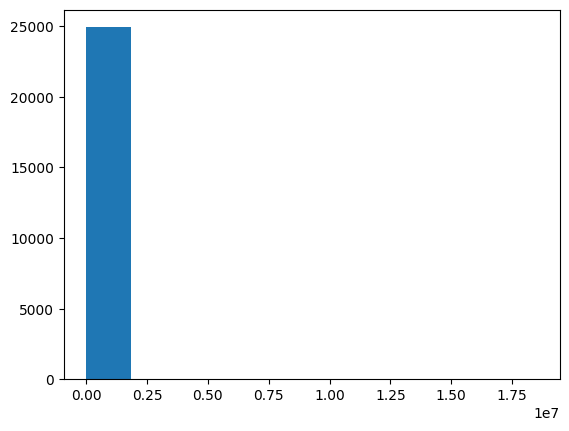

In [134]:
pyplot.hist(df["claimam_div_exposure"].astype(int))

In [ ]:
rows: int = df.shape[0]
df.isna().sum() / rows

IDpol                   0.0
ClaimNb                 0.0
Exposure                0.0
Area                    0.0
VehPower                0.0
VehAge                  0.0
DrivAge                 0.0
BonusMalus              0.0
VehBrand                0.0
VehGas                  0.0
Density                 0.0
Region                  0.0
ClaimAmount             0.0
claimam_div_exposure    0.0
ClaimAmount_max         0.0
dtype: float64

In [132]:
df.head(12) 

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,claimam_div_exposure
7841,1120377.0,1.0,0.22,'B',9.0,13.0,19.0,100.0,'B2',Regular,93.0,'R24',4075400,1.852455e+07
2967,110846.0,2.0,0.43,'C',6.0,13.0,20.0,100.0,'B1',Regular,203.0,'R24',1403057,3.262923e+06
13399,2141337.0,1.0,0.32,'D',4.0,14.0,18.0,100.0,'B2',Regular,863.0,'R82',1301172,4.066162e+06
18030,3122016.0,1.0,0.91,'E',7.0,7.0,40.0,63.0,'B11',Diesel,9307.0,'R82',774411,8.510011e+05
10260,2008127.0,3.0,0.36,'D',4.0,2.0,57.0,50.0,'B4',Regular,1217.0,'R82',390742,1.085394e+06
16202,3025890.0,2.0,0.09,'A',7.0,1.0,36.0,50.0,'B12',Diesel,38.0,'R21',369131,4.101456e+06
7703,1117644.0,1.0,0.85,'C',7.0,1.0,21.0,90.0,'B3',Diesel,108.0,'R53',307096,3.612894e+05
3956,158309.0,1.0,0.75,'A',6.0,3.0,46.0,50.0,'B1',Diesel,10.0,'R24',301635,4.021800e+05
17094,3075820.0,1.0,0.58,'E',7.0,18.0,78.0,50.0,'B10',Regular,4762.0,'R93',287423,4.955569e+05
18787,3150210.0,1.0,0.48,'D',6.0,4.0,61.0,54.0,'B3',Diesel,1064.0,'R24',281897,5.872854e+05


In [ ]:
df.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimAmount',
       'claimam_div_exposure'],
      dtype='object')

In [137]:
selected_cols: list[str] = AI_FEATURES_WHILE_TRAINING + AI_TARGET_LABEL

In [138]:
### impute missing values
df: pd.DataFrame = df[selected_cols]

In [139]:
# Area VehBrand VehGas Region
if "Area" in selected_cols:
    df.loc[:, ('Area')]: pd.Series = df['Area'].astype("category")
    le_area: LabelEncoder = LabelEncoder()
    df.loc[:, ('Area')]: pd.Series = le_area.fit_transform(df['Area'])
if "VehBrand" in selected_cols:
    df.loc[:, ('VehBrand')]: pd.Series = df['VehBrand'].astype("category")
    le_brand: LabelEncoder = LabelEncoder()
    df.loc[:, ('VehBrand')]: pd.Series = le_brand.fit_transform(df['VehBrand'])
if "VehGas" in selected_cols:
    df.loc[:, ('VehGas')]: pd.Series = df['VehGas'].astype("category")
    le_gas: LabelEncoder = LabelEncoder()
    df.loc[:, ('VehGas')]: pd.Series = le_gas.fit_transform(df['VehGas'])
if "Region" in selected_cols:
    df.loc[:, ('Region')]: pd.Series = df['Region'].astype("category")
    le_region: LabelEncoder = LabelEncoder()
    df.loc[:, ('Region')]: pd.Series = le_region.fit_transform(df['Region'])

In [140]:
df.head()

,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,claimam_div_exposure
7841,1.0,1,9.0,13.0,19.0,100.0,6,1,93.0,4,1.852455e+07
2967,2.0,2,6.0,13.0,20.0,100.0,0,1,203.0,4,3.262923e+06
13399,1.0,3,4.0,14.0,18.0,100.0,6,1,863.0,17,4.066162e+06
18030,1.0,4,7.0,7.0,40.0,63.0,2,0,9307.0,17,8.510011e+05
10260,3.0,3,4.0,2.0,57.0,50.0,8,1,1217.0,17,1.085394e+06


In [141]:
### train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df[AI_FEATURES_WHILE_TRAINING],
    df[AI_TARGET_LABEL],
    train_size=AI_TRAIN_RATIO,
    test_size=AI_TEST_RATIO,
)

In [142]:
# train AI model
xgb_model: NGBRegressor = NGBRegressor(**AI_MODEL_HYPER_PARAMETERS, random_state=RANDOM_SEED)
xgb_model.fit(X=X_train, Y=y_train)

y_preds: np.ndarray = xgb_model.predict(X=X_test)

c:\Users\obudurov\huk\.conda\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\obudurov\huk\.conda\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\obudurov\huk\.conda\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\obudurov\huk\.conda\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\obudurov\huk\.conda\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 0] loss=13.7895 val_loss=0.0000 scale=0.5000 norm=8034.4696


c:\Users\obudurov\huk\.conda\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 100] loss=12.5064 val_loss=0.0000 scale=2.0000 norm=30658.5465
[iter 200] loss=11.9255 val_loss=0.0000 scale=2.0000 norm=29686.3916
[iter 300] loss=11.7135 val_loss=0.0000 scale=2.0000 norm=29452.2466
[iter 400] loss=11.6573 val_loss=0.0000 scale=0.5000 norm=7369.3715
[iter 500] loss=11.5784 val_loss=0.0000 scale=0.1250 norm=1849.8556
[iter 600] loss=11.5480 val_loss=0.0000 scale=0.1250 norm=1850.0672
[iter 700] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 800] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 900] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1000] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1100] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1200] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1300] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1400] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.0004
[iter 1500] loss=11.5131 val_loss=0.0000 scale=0.0000 norm=0.000

In [ ]:
# AI predictions
mae: float = mean_absolute_error(y_true=y_test, y_pred=y_preds)
f'MAE = {mae:.3f} EUR per year -- [0, infinite) -- lower is better'

'MAE = 13221.151 EUR -- [0, infinite) -- lower is better'

In [ ]:
importances: pd.DataFrame = pd.DataFrame(columns=["feature", "importance"])
importances["feature"].astype(np.str_)
importances["importance"].astype(np.float64)

importances["feature"] = pd.Series(data=AI_FEATURES_WHILE_TRAINING)
importances["importance"] = xgb_model.feature_importances_[0]

importances.sort_values(by=["importance", "feature"], 
                        inplace=True, 
                        ascending=False,
                        kind="quicksort")

importances.reset_index(inplace=True)
importances.drop(columns=["index"], inplace=True)

In [ ]:
importances

,feature,importance
0,DrivAge,0.252206
1,Exposure,0.241140
2,VehPower,0.210390
3,Density,0.106615
4,VehAge,0.094675
5,Region,0.040826
6,BonusMalus,0.021307
7,VehBrand,0.019503
8,Area,0.005550
9,ClaimNb,0.004554
